# The RBM flow and the Critical Temperature of Ising Models

This is the notebook for the paper X.

Firstly, we import the necessary Python packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pickle

import torch
import torch.nn as nn
torch.manual_seed(12)

from MC_Ising2D import IsingMC
from net import Net
from rbm import RBM
L = 100
Tc_Ons = 2 / ( np.log(1 + np.sqrt(2)) )
Tc_MF = 4.0

The neural network thermometer is called by the following function.

In [2]:
def thermometer(flow_,
                ising_data,
                L= 100,
                x= 0,
                step= 2,
                save= False,
                Tzero= True, 
                x_text= 0,
                y_text= 0.15,
                errorbar= True,
                publication= False,
                training_set= 'COMPLETE',
                loc_legend= 'lower right',
                NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt'):
    
    net = Net()
    net = torch.load(NN_path)  
    
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 12.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
       
    for j in range(0, len(flow_) - x, step):
        
        prediction = net(flow_[j])
        
        if errorbar:
                   
            plt.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j )
            
        else:
            
            plt.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     label= 'It = %d' % j )
        
        
        plt.axvline(x= Tc_Ons, linestyle= ':', linewidth= 0.8, color= 'black')
        
        plt.xlabel('Temperature scale', fontsize= fontsize_l)
        plt.ylabel('Softmax probability', fontsize= fontsize_l)
        
    plt.legend(fontsize= fontsize_lg,
               loc= loc_legend)
    
    if Tzero:
        plt.text(x= x_text, y= y_text, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        plt.text(x= x_text, y= y_text, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if Tzero:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig, bbox_inches='tight')
        else:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_Train%s_ONLY_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_ONLY_Train%s_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
                           
    plt.show()

We also define the function `thermometer_joint_plot`, which can plot two different flows in the same figure.

In [3]:
def thermometer_joint_plot(flow_1,
                           flow_2,
                           ising_data= None,
                           L= 100,
                           x1= 0,
                           x2= 0,
                           step1= 2,
                           step2= 2,
                           save= False,
                           Tzero1= True,
                           Tzero2= True,
                           x_text1= 0,
                           y_text1= 0.15,
                           x_text2= 0,
                           y_text2= 0.15,
                           errorbar1= False,
                           errorbar2= True,
                           publication= False,
                           training_set= 'COMPLETE',
                           loc_legend1= 'lower right',
                           loc_legend2= 'lower right',
                           NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt'):
    
    net = Net()
    net = torch.load(NN_path) 
    
    if publication:
        fig = plt.figure(figsize=(3.375, 
                                  2*0.678*3.375))
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_ticks = 6.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.5
        
        if save:
            if errorbar1 == errorbar2:
                path_fig = 'figures/PUB_flow_L%d_Train%s_TinZERO_and_TinINF_errobar_both%s.pdf' % (L,
                                                                                                   training_set,
                                                                                                   str(errorbar1))
            else:
                path_fig = 'figures/PUB_flow_L%d_Train%s_TinZERO%s_errobar_plot2_%s.pdf' % (L,
                                                                                            training_set,                                                                                                   
                                                                                            str(Tzero1), 
                                                                                            str(errorbar2))
                
        
    else:
        fig = plt.figure(figsize=(plt.rcParams.get('figure.figsize')[0],
                                  2*plt.rcParams.get('figure.figsize')[1]))
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 10.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
        linewidth_v= 0.8
        
        if save:
            if errorbar1 == errorbar2:
                path_fig = 'figures/flow_L%d_Train%s_TinZERO_and_TinINF_errobar_both%s.pdf' % (L,
                                                                                               training_set,
                                                                                               str(errorbar1))
            else:
                path_fig = 'figures/flow_L%d_Train%s_TinZERO%s_errobar_plot2_%s.pdf' % (L, 
                                                                                        training_set,
                                                                                        str(Tzero1), 
                                                                                        str(errorbar2))
        
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
        
    ### ax1 plot
    
    color_counter = 0
       
    for j in range(0, len(flow_1) - x1, step1):
        
        prediction = net(flow_1[j])
        
        if errorbar1:
                   
            ax1.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j,
                         color= 'C%d' % color_counter)
            
        else:
            
            ax1.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize - 1.0,
                     linewidth= linewidth,
                     label= 'It = %d' % j,
                     color= 'C%d' % color_counter)
            
        color_counter = color_counter + 1
        
        ax1.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
        
        ax1.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax1.legend(fontsize= fontsize_lg,
               loc= loc_legend1)
    
    if Tzero1:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax1.set_ylim(0.0, ax1.set_ylim()[1])
    if publication:
        ax1.tick_params(axis="y", labelsize= fontsize_ticks)
        ax1.tick_params(axis="x", labelsize= fontsize_ticks)
    ax1.set_xticklabels([])
    
    ### ax2 plot
    
    color_counter = 0
       
    for j in range(0, len(flow_2) - x2, step2):
        
        prediction = net(flow_2[j])
        
        if errorbar2:
                   
            ax2.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j,
                         color= 'C%d' % color_counter)
            
        else:
            
            ax2.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize - 1.0,
                     linewidth= linewidth,
                     label= 'It = %d' % j, 
                     color= 'C%d' % color_counter)
            
        if step2 >= step1:
            ps = step2 / step1
        else:
            ps = 1
            
        color_counter = color_counter + int(ps)
        
        
        ax2.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
        
        ax2.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax2.legend(fontsize= fontsize_lg,
               loc= loc_legend2)
    
    if Tzero2:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax2.set_ylim(0.0, ax2.set_ylim()[1])
    if publication:
        ax2.tick_params(axis="y", labelsize= fontsize_ticks)
        ax2.tick_params(axis="x", labelsize= fontsize_ticks)
                

    ax1.get_shared_x_axes().join(ax1, ax2)
    
    plt.subplots_adjust(hspace=.05)
    
    plt.xlabel('Temperature scale', fontsize= fontsize_l)
    
    if save:
        plt.savefig(path_fig , bbox_inches='tight')

    plt.show()

The magnetization can be also be analyzed during flow dynamics.

In [4]:
def magnetization(flow_low,
                  flow_high,
                  L= 100,
                  errorbar= True,
                  fill_error= False, 
                  Tzero= True,
                  x= 0, 
                  step= 1,
                  loc_legend= 'lower right',
                  training_set= 'COMPLETE',
                  save= False, 
                  publication= False):
              
    mag_low= []
    er_bar_low= []
    x_axis= [] 
    
    for j in range(0, len(flow_low)- x, step):
        flow = 2*flow_low[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_low.append(mag.item())
        er_bar_low.append(error_bar.item())
        x_axis.append(j)
        
    mag_high= []
    er_bar_high= []
        
 
    for j in range(0, len(flow_high)- x, step):
        flow = 2*flow_high[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_high.append(mag.item())
        er_bar_high.append(error_bar.item())
  

    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize = 10.0
        linewidth= 0.8
        fontsize_l = 12.0
        fontsize_t = 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth = 0.5
        
    if errorbar:
                                                 
        plt.errorbar(x_axis,
                     mag_low,
                     yerr= er_bar_low,
                     label= '$T_{0}=0$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
        
        plt.errorbar(x_axis,
                     mag_high,
                     yerr= er_bar_high,
                     label= '$T_{0}  = \infty$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
   
    else:
        
        plt.plot(x_axis, 
                 mag_low,
                 label= '$T_{0}=0$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        if fill_error:
            plt.fill_between(np.array(x_axis), 
                             np.array(mag_low) - np.array(er_bar_low),
                             np.array(mag_low) + np.array(er_bar_low),
                             alpha= 0.1)
            
        
        plt.plot(x_axis, 
                 mag_high,
                 label= '$T_{0} = \infty$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        if fill_error:
            plt.fill_between(np.array(x_axis), 
                             np.array(mag_high) - np.array(er_bar_high),
                             np.array(mag_high) + np.array(er_bar_high),
                             alpha= 0.1)
        
    plt.xlabel('Flow iteration', fontsize= fontsize_l)
    plt.ylabel('$m$', fontsize= fontsize_l)
    
    plt.legend(fontsize= fontsize_t,
               loc= loc_legend)
    
    #plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if publication:
            if fill_error:
                path_fig = 'figures/PUB_mag_flow_L%d_Train%s_ONLY_errorfilled.pdf' % (L, training_set)
            else:
                path_fig = 'figures/PUB_mag_flow_L%d_Train%s_ONLY_errorbar.pdf' % (L, training_set)
                
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            if fill_error:
                path_fig = 'figures/mag_flow_L%d_Train%s_ONLY_errorfilled.pdf' % (L, training_set)
            else:
                path_fig = 'figures/mag_flow_L%d_Train%s_ONLY_errorbar.pdf' % (L, training_set)
                
            plt.savefig(path_fig, bbox_inches='tight')
    
    plt.show()

## Scale-invariant feature extraction


### Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `data/L100_1000sweeps.pkl` was constructed considering a square lattice $L\times L$, with $L=100$. There are 1000 spins configurations for each of 29 different temperatures $ T/J = 1, 1.1, 1.2, ..., 3.5 $ and $ T/J = 2.259, 2.269, 2.279$.

In [5]:
ising_data = pd.read_pickle('data/L100_Ising2D_MC.pkl')
ising_data.head()

,energy,magn,state,temp
0,-6656,176,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",3.5
1,-6872,-248,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...",3.5
2,-6812,544,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...",3.5
3,-6616,-166,"[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...",3.5
4,-6660,-68,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",3.5


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

The temperatures values near $ T_c$ were included in the dataset just to get a better visualization (which is a sanity check) of the Monte Carlo results for thermodynamics quantities. They are not necessary for the present discussion, as pointed out by the paper [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172).

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


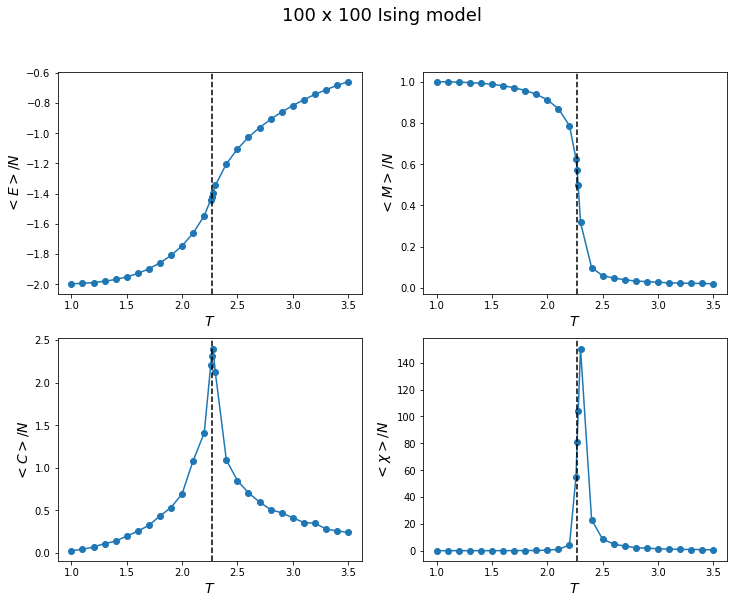

In [6]:
IsingMC(L= 100).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

## Flow from RBM trained with 29 different temperatures

First we load the trained RBM model.

In [7]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_complete_nv10000_nh10000_lr1.0E-03_k1_bsize100_nepochs800.pt')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'rbm.RBM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


For the sake of completeness, we take a look at the weights distribution.

In [ ]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

In [ ]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_V, sigmaW_V = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_V, sigmaW_V) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_V, sigmaW_V ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-1, 1])
plt.legend()
plt.show()

In [ ]:
del W
torch.cuda.empty_cache()

### RBM flow


#### Initial temperature: $T_0= 0$

In [8]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [9]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [19]:
with open('RBM_flows/rbm_flow_L100_ALL_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [10]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


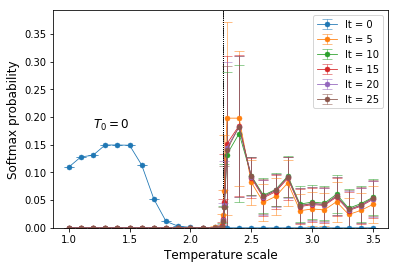

In [18]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 1.2,
            y_text= 0.18,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


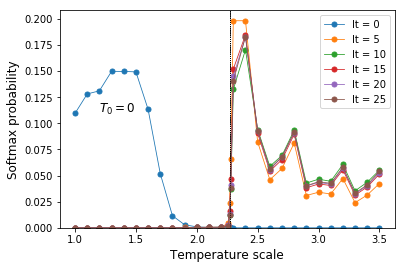

In [16]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 1.2,
            y_text= 0.11,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperature: $T = \infty$

In [22]:
L = 100
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [23]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

RuntimeError: CUDA error: out of memory

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [ ]:
with open('RBM_flows/rbm_flow_L100_ALL_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [ ]:
flow__ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

In [ ]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Saving the figure with the predefined pattern for publication.

In [ ]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= True,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

We also the dynamics of the magnetization.

In [ ]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= False, 
              publication= False)

In [ ]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= False, 
              publication= True)

## Flow from RBM trained only with $T=0$ and $ T = \infty$

In order to investigate the RBM flow in an extreme situation, we have trained the machine in an dataset composed only by frozen and random states. This still satisfies the condition shown in the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172): the RBM flow would go towards the critical value if the data training set has states with temperature values less and greater than the critical one.

It is crucial to note that, since the visible layer is always fed with an unidimensional vector (an array is transformed in a vector to be fed in the visible layer), the machine does not have any geometric information about the lattice in this case.

### RBM flow

In [3]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_zero_inf_nv10000_nh10000_lr1.0E-03_k1_bsize100_nepochs1000.pt',
                 map_location= 'cpu')

For the sake of completeness, we take a look at the weights distribution.

In [48]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

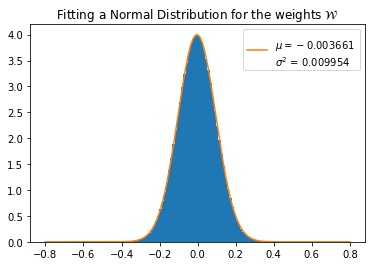

In [49]:
#W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))
W_ = W.numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, bins= 100, density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
mu_HL, sigma_HL = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, mu_HL, sigma_HL) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 1.5,
         label= '$\mu= %.6f$ \n$\sigma$ = %.6f' % (mu_HL, sigma_HL))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.legend()
plt.show()

### RBM flow

#### Initial temperature: $T_0= 0$

In [7]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [8]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [20]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [8]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_zero_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [9]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


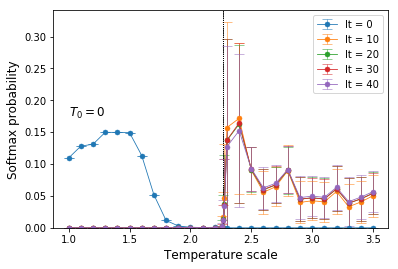

In [23]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.175,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


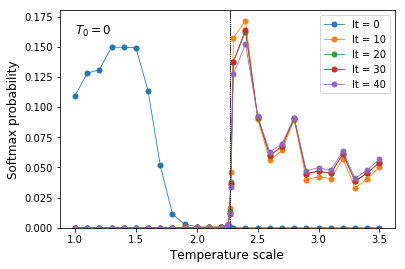

In [18]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.16,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

In [21]:
del flow_
torch.cuda.empty_cache()

#### Initial temperature: $T = \infty$

In [6]:
L = 100
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [9]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [16]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [19]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_inf_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [20]:
flow__ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


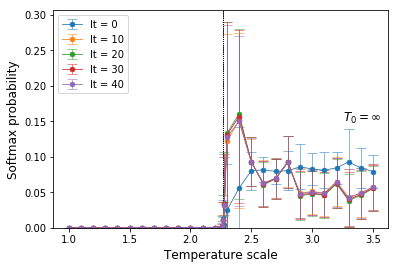

In [24]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


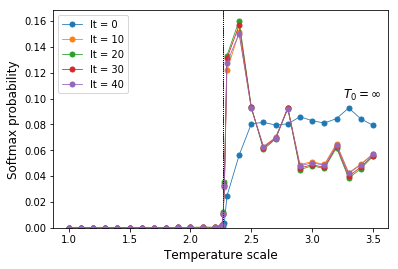

In [27]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.10,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperatures $T_0 = 0$ and $T_0 = \infty$ plots in the same figure

We can also take a look at the flows from $T_0 = 0$ and $T_0 = \infty$ in the same figure. 

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


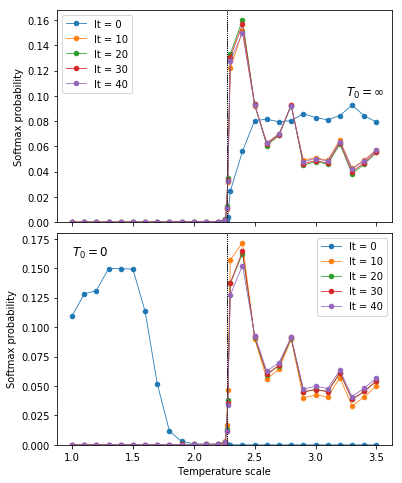

In [30]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= 100,
                       x1= 0,
                       x2= 0,
                       step1= 10,
                       step2= 10,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 3.25,
                       y_text1= 0.1,
                       x_text2= 1.0 ,
                       y_text2= 0.16,
                       errorbar1= False,
                       errorbar2= False,
                       publication= False,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'LOW_HIGH',
                       NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

The figure above was selected for publication, then (to set the predefined pattern) we run again the `thermometer_joint_plot` function with `publication= True`.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


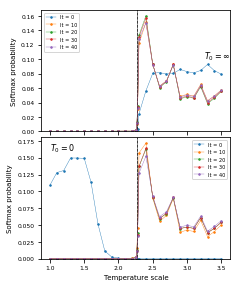

In [29]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= 100,
                       x1= 0,
                       x2= 0,
                       step1= 10,
                       step2= 10,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 3.25,
                       y_text1= 0.1,
                       x_text2= 1.0 ,
                       y_text2= 0.16,
                       errorbar1= False,
                       errorbar2= False,
                       publication= True,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'LOW_HIGH',
                       NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Magnetization dynamics

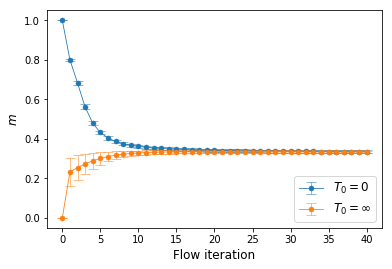

In [33]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'lower right',
              training_set= 'LOW_HIGH',
              publication= False)

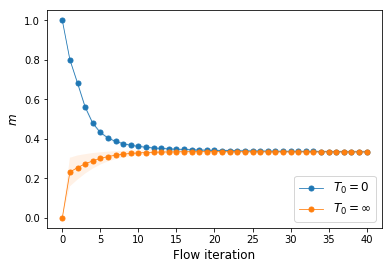

In [36]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'lower right',
              training_set= 'LOW_HIGH',
              publication= False)

The figure above was selected for publication, then (to set the predefined pattern) we run again the `magnetization` function with `publication= True`.

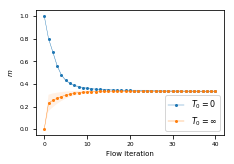

In [38]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'lower right',
              training_set= 'LOW_HIGH',
              publication= True)

## Comparison between weight distributions

Now we compare the weight distribution from the four trained RBMs. The following two cells just set some plot convenient plot values. 

In [ ]:
publication= False
save = False

In [ ]:
if publication:
    fontsize_lg = 3.0
    linewidth= 0.5
    figsize= (3.375, 0.678*3.375)
    fontsize_t = 3.0
    linewidth_v = 0.3
    axis_width = 0.5
    
    if save:
        
        path_fig = 'figures/PUB_W_distrib_L%d.pdf' % L
        
else:
    
                 
    fontsize_lg = 13.0
    linewidth= 2.0
    figsize= (15, 10)
    fontsize_t = 12.0
    linewidth_v = 1.0
    axis_width = 1.0
        
    if save:
                
        path_fig = 'figures/W_distrib_L%d.pdf' % L

The four distributions are compared in a a figure constructed with [matplotlib.pyplot.subplots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html).

In [ ]:
f, axs = plt.subplots(2, 2,
                      figsize= figsize)


x_L = np.linspace(-1.25, 1.25, 500)
x_HL = np.linspace(-5, 5, 500)
x_H = np.linspace(-1.75, 1.75, 500)
x_V = np.linspace(-5, 5, 500)

#######################

axs[0, 0].plot(x_L,
               kde0(x_L) / max(kde0(x_L)),
               linewidth= linewidth,
               label= '$ T = 10^{-6}$')


axs[0, 0].fill_between(x_L,
                       kde0(x_L) / max(kde0(x_L)),
                       0,
                       alpha=0.1)

axs[0, 0].set_ylim([0.0, axs[0, 0].set_ylim()[1]])
axs[0, 0].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[0, 0].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[0, 0].locator_params(axis='y', nbins=6)
axs[0, 0].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[0, 0].spines[axis].set_linewidth(axis_width)
    

#######################


axs[0, 1].plot(x_V,
               stats.norm.pdf(x_V, muW_V, sigmaW_V), 
               linewidth= linewidth,
               label= '$T=10^{-6}, ..., 6$')

axs[0, 1].axvline(x= muW_V, linestyle= ':', linewidth= linewidth_v, color= 'black')

axs[0, 1].fill_between(x_V,
                       stats.norm.pdf(x_V, muW_V, sigmaW_V),
                       0, 
                       alpha=0.1)

x_percentil_V = np.linspace(muW_V - sigmaW_V, muW_V + sigmaW_V, 500) 

axs[0, 1].fill_between(x_percentil_V,
                       stats.norm.pdf(x_percentil_V, muW_V, sigmaW_V),
                       0, 
                       alpha=0.2)

axs[0, 1].set_ylim([0.0, axs[0, 1].set_ylim()[1]])
axs[0, 1].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[0, 1].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[0, 1].locator_params(axis='y', nbins=6)
axs[0, 1].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[0, 1].spines[axis].set_linewidth(axis_width)

#################


axs[1, 0].plot(x_HL, 
               stats.norm.pdf(x_HL, muW_HL, sigmaW_HL), 
               linewidth= linewidth,
               label= '$T=0$ and $T=\infty$')

axs[1, 0].axvline(x= muW_HL, linestyle= ':', linewidth= linewidth_v, color= 'black')

axs[1, 0].fill_between(x_HL, 
                       stats.norm.pdf(x_HL, muW_HL, sigmaW_HL),
                       0, 
                       alpha=0.1)

x_percentil_L = np.linspace(muW_HL - sigmaW_HL, muW_HL + sigmaW_HL, 500) 

axs[1, 0].fill_between(x_percentil_L, 
                       stats.norm.pdf(x_percentil_L, muW_HL, sigmaW_HL),
                       0, 
                       alpha=0.2)

axs[1, 0].set_ylim([0.0, axs[1, 0].set_ylim()[1]])
axs[1, 0].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[1, 0].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[1, 0].locator_params(axis='y', nbins=6)
axs[1, 0].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[1, 0].spines[axis].set_linewidth(axis_width)


#########################

axs[1, 1].plot(x_H, 
               stats.norm.pdf(x_H, muW_H, sigmaW_H), 
               linewidth= linewidth,
               label= '$ 4 \geq T \geq 6$')

axs[1, 1].axvline(x= muW_H, linestyle= ':', linewidth= linewidth_v, color= 'black')

axs[1, 1].fill_between(x_H, 
                       stats.norm.pdf(x_H, muW_H, sigmaW_H),
                       0, 
                       alpha=0.1)

x_percentil_H = np.linspace(muW_H - sigmaW_H, muW_H + sigmaW_H, 500) 

axs[1, 1].fill_between(x_percentil_H, 
                       stats.norm.pdf(x_percentil_H, muW_H, sigmaW_H),
                       0, 
                       alpha=0.2)

axs[1, 1].set_ylim([0.0, axs[1, 1].set_ylim()[1]])
axs[1, 1].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[1, 1].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[1, 1].locator_params(axis='x', nbins=7)
axs[1, 1].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[1, 1].spines[axis].set_linewidth(axis_width)


if save:
    plt.savefig(path_fig , bbox_inches='tight')

plt.show()

### Weight distribution

Once we have checked that the flow path towards the critical temperature does not depend on the geometry of the lattice, we investigate whether it depends or not on the specif values obtained by the training procedure.

## RBM Flow - Sampling from the weight distribution

### Quenched version

In [9]:
float(mu)

-0.0036607130896300077

In [7]:
sigma

0.09976824

#### Initial temperature: $T= 0$

In [22]:
n_states = 200

mu = -0.001
sigma = np.sqrt(0.0015)


v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

flow = []
flow.append(v0)
n_it_flow = 20

for l in range(n_it_flow):
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    flow_ = rbm_.sampling(k_sampling= 1, v0= v0)
    
    flow.append(flow_)
    
    v0 = flow_.clone()

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


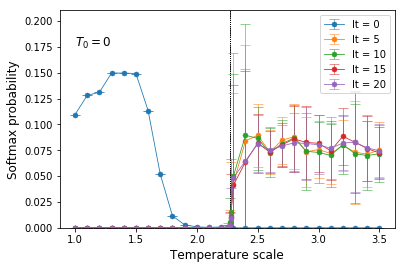

In [23]:
flow_ = [ x.cuda() for x in flow ]

thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.175,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperature: $T= \infty$

In [27]:
n_states = 200

mu = -0.001
sigma = np.sqrt(0.0015)

#####

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(n_states - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

#####    
    
flow = []
flow.append(v0)
n_it_flow = 40

for l in range(n_it_flow):
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    flow_ = rbm_.sampling(k_sampling= 1, v0= v0)
    
    flow.append(flow_)
    
    v0 = flow_.clone()

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


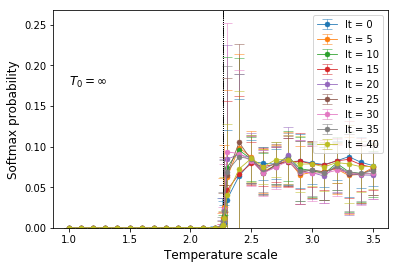

In [30]:
flow_ = [ x.cuda() for x in flow ]

thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 1.0,
            y_text= 0.175,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

### Annealed version

#### Initial temperature: $T= 0$

In [ ]:
n_states = 1000

##### Initial State - T zero

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

################################
    
flow = []
flow.append(v0)
n_it_flow = 20

for l in range(n_it_flow):
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, h = rbm_.v_to_h(v= v0)
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, flow_ = rbm_.h_to_v(h= h)
    
    flow.append(flow_)
    v0 = flow_.clone()

#### Initial temperature: $T= \infty$

In [ ]:
mu = -0.001
sigma = np.sqrt(0.0015)

In [53]:
n_states = 1000


##### Initial State - T infinity

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(n_states - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

################################
    
    
flow = []
flow.append(v0)
n_it_flow = 30

for l in range(n_it_flow):
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu.item(),
                         std= sigma.item())
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, h = rbm_.v_to_h(v= v0)
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu.item(),
                         std= sigma.item())
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, flow_ = rbm_.h_to_v(h= h)
    
    flow.append(flow_)
    v0 = flow_.clone()

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


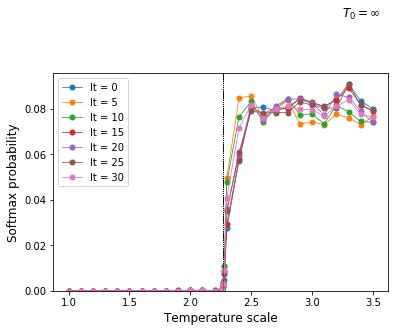

In [54]:
flow_ = [ x.cuda() for x in flow ]

thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.12,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')